Fold 1: Final Training Loss: 0.0058, Final Validation Loss: 0.0002
Fold 2: Final Training Loss: 0.0062, Final Validation Loss: 0.0002
Fold 3: Final Training Loss: 0.0053, Final Validation Loss: 0.0002
Fold 4: Final Training Loss: 0.0053, Final Validation Loss: 0.0003
Fold 5: Final Training Loss: 0.0051, Final Validation Loss: 0.0002


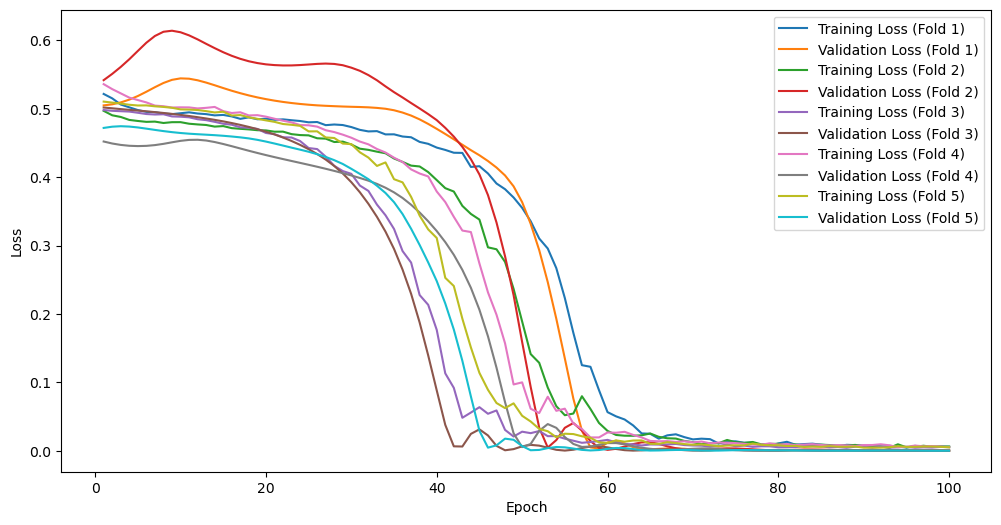

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Generate sinusoidal time series data
def generate_sin_wave(freq, num_samples, sample_rate):
    x = np.linspace(0, num_samples / sample_rate, num_samples)
    y = np.sin(2 * np.pi * freq * x)
    return y

# Create input-target pairs for the LSTM model
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length - 1):
        seq = data[i : (i + seq_length)]
        X.append(seq)
        target = data[i + seq_length]
        y.append(target)
    return np.array(X), np.array(y)

# Define the LSTM model with dropout
class TimeSeriesLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(TimeSeriesLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Generate sinusoidal time series data
freq = 2
num_samples = 200
sample_rate = 10
data = generate_sin_wave(freq, num_samples, sample_rate)

# Prepare the data for the LSTM model
seq_length = 20
X, y = create_sequences(data, seq_length)
X = X.reshape(X.shape[0], X.shape[1], 1)
y = y.reshape(y.shape[0], 1)

# Function to train and validate the model
def train_and_validate(X_train, y_train, X_val, y_val, num_epochs, device):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

    model = TimeSeriesLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob=dropout_prob).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            val_losses.append(val_loss.item())

    return train_losses, val_losses

# Perform 5-fold cross-validation
num_epochs = 100
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

train_losses_all = []
val_losses_all = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    X_train, X_val = X[train_indices], X[val_indices]
    y_train, y_val = y[train_indices], y[val_indices]

    train_losses, val_losses = train_and_validate(X_train, y_train, X_val, y_val, num_epochs, device)
    train_losses_all.append(train_losses)
    val_losses_all.append(val_losses)

    print(f"Fold {fold + 1}: Final Training Loss: {train_losses[-1]:.4f}, Final Validation Loss: {val_losses[-1]:.4f}")

# Plot training and validation losses
plt.figure(figsize=(12, 6))
for i in range(k_folds):
    plt.plot(range(1, num_epochs + 1), train_losses_all[i], label=f"Training Loss (Fold {i + 1})")
    plt.plot(range(1, num_epochs + 1), val_losses_all[i], label=f"Validation Loss (Fold {i + 1})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

